# Reaction-diffusion model
This exercise will walk through a simple implementation of a reaction-diffusion model. This model is based on Alan Turing's proposal on how patterns in biology can form through the diffusion of chemicals he called *morphogens*. Here, we will implement a popular algorithm that simulates this type of chemical reaction which is called the *Gray-Scott* Algorithm. 

This algorithm is not an optimization strategy, rather, it is a type of indirect encoding where a few basic rules lead to the emergence of complex patterns. 

To create the model we will use the *pygame* package as our visualization tool. We use pygame instead of matplotlib to speed up the visualization process a bit. This implementation of the Gray-Scott algorithm is by no means computationally efficient as the purpose of this exercise is to allow you to understand the algorithm. To increase the performance of the algorithm, one could look at implementations in *Shader Toy* or *processing*. To make a more efficient algorithm in python would likely make use of efficient matrix transformations in numpy instead of the OOP manner which this example shows.     



## Libraries


In [1]:
import numpy as np
import pygame
import copy
import random
import math

from IPython.display import Image 

pygame 2.0.1 (SDL 2.0.14, Python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


### Introduction

For this algorithm we are going to use the aforementioned *Gray-Scott* algorithm. This algorithm assumes that two chemicals will influence the expression of one another in a dynamic way. The equations and the explanation of the symbols can be seen below. Here we use two chemicals that we will refer to as chemical A and chemical B. A will be a molecule that will be expressed regardless of the other chemical. In the presence of B, A can be converted to B via a *reaction*. This reaction decreases the amount of A and increases the amount of B. B will be activated by the presence of itself plus chemical A.  
Note that the constants Da and Db can be altered to change the emerging patterns. These constants are sensitive so it can be that when you change them nothing will happen. 

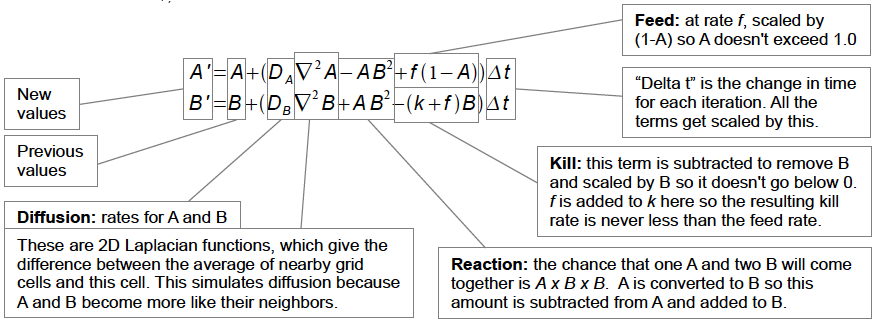

In [2]:
Image("formulas.png") # from Karl Sims' tutorial website

## Setting up global variables
From the formula above we can define the constants Da, Db, the laplace transform matrix, the 'feed' and the 'kill' rate. Changing these values will give you different expressions. 

In [3]:
# Diffusion rates for A and B
dA = 1.0
dB = 0.2
feed = 0.065
kill = 0.062


In [4]:
# This is the matrix used by the Laplacian transform function
laplace_matrix = np.array([[0.05, 0.2,0.05],
					  [0.2, -1,0.2],
					  [0.05,0.2,0.05]])


Some more variables will be usefull to alter some general settings of our simulation. 

In [5]:
# speed variable to modify speed of diffusion
speed = 0.5 # should not be set to more than 1.0
# scale variable to change the granularity of the output
scale = 10
# The pygame display size (in number of pixels)
width = 600
height = 600
# width*height/scale will equal the number of cells we simulate

## Laplace transform matrix function

The Laplace transform function takes in the coordinates of a specific cell, and adjusts returns the gradient sum of either chemical A or B. The function requires to look at neighbouring cells and here I decided to pass the cells along as an argument of the function. I added an argument called *adjustA*, which is a bit silly, but this simply tells the function whether it needs to look at chemical A or B. 

In [6]:
def laplace(cells, x, y, adjustA = True):
    sum = 0	
    for i in range(-1,2):
        for j in range(-1,2):
            x_= x+i
            y_ = y+j
            if x_ >= len(cells):
                x_ = 0
            if y_ >= len(cells):
                y_ = 0
            if (adjustA):
                sum += cells[x_][y_].A * laplace_matrix[i+1][j+1]
            else:
                sum += cells[x_][y_].B * laplace_matrix[i+1][j+1]
    return sum

### Simple cell object

The only parameters our cells need to have are the concentrations of chemical A and B. When we create a new cell instance, we set the amount of A to 1, and B to 0. 

In [7]:
class Cell:
    def __init__(self):
        self.A = 1
        self.B = 0

### Creating cells through a reset function

To create all the cells of this model, we create a two dimensional array cells. The number of cells we create is based on the size of the pygame window and the scale parameter we set as a general parameter above. We can make sure to call this reset function later. Since all cells start of with a value of 1. for chemical A, we also need to populate some cells with chemical B. Below two if statements ensure that a squared patch in the middle of the screen will be populated with chemical B. To randomly add chemical B to cells, set the optional reset argument *randomly_assign_b* to *True*. 

In [8]:
def reset(width, height, scale, randomize = False, randomly_assign_b = False):
    cells = []
    for i in range(0,width,scale):
        row = []
        for j in range(0,height,scale):
            c= Cell()
            if(randomly_assign_b):
                if (random.uniform(0,1) < 0.1):
                   c.B = 1
            else:
                if (i > width/2-5* scale) and (i < width/2+5* scale):
                	if (j > height/2-5* scale) and (j <height/2+5* scale):
                		c.B = 1.0
            row.append(c)
        cells.append(row)
    return cells

### Function to display cells
To display the cells, the colors are adjusted based on the amount of chemical A and B present. We can simply draw cells by calling the *pygame.draw.rect* function. In addition, to see which chemicals are present, we color a cell red based on the amount of chemical A, and we color the cell blue based on the amount of chemical B.  

In [9]:
def display_cells(screen, cells, scale):
	for i,cell_row in enumerate(cells):
		for j,c in enumerate(cell_row):
			col = [0,0,0]
			if (c.A > 0):
				if (c.A < 1.0):
					col[0] = int(c.A * 255)
				else:
				   col[0] = 255
			if (c.B > 0):
				if (c.B < 1.0):
					col[2] = int(c.B * 255)
				else:
				   col[2] = 255
			color = col
			pygame.draw.rect(screen, color,[i * scale , j*scale, int(scale), int(scale)])



### Function for updating the cells

To update the cells, the we simply loop over all of the cells stored in the 2D array, and alter their chemical A and B based on the equations. 

In [10]:
def update_cells(cells):
	# The values of the chemicals need to be deep copied since we don't want the values of A and B that are changed, to influence how the next cell updates. This shows you a performance limitation of this OOP implementation of the Gray-Scott algorithm.
	cell_buffer = copy.deepcopy(cells)
	for i,cell_row in enumerate(cells):
		for j,c in enumerate(cell_row):
			a = c.A # get value chemical A
			b = c.B # get value chemical B
			# The equations
			c.A = a + (dA*laplace(cell_buffer, i,j, adjustA = True) - (a * b * b) + (feed*(1-a)))*speed *  random.uniform(0.9,1.1)
			c.B = b + (dB*laplace(cell_buffer, i,j, adjustA=False) + (a * b * b) - (kill+feed)*b)*speed *  random.uniform(0.9,1.1)

	cells = cell_buffer

### The main function

In [11]:
def main():
    # Create the 2D array with cells. 
    cells = reset(width,height, scale)
    screen = pygame.display.set_mode((width, height))
    pygame.display.set_caption('Ultisequencer')
    background_color = (255,255,255)
    running = True
    while running:
        screen.fill(background_color)
        display_cells(screen, cells, scale)
        update_cells(cells)
        pygame.display.update()
        for event in pygame.event.get():
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_UP:
                    interval+=1
                    print("interval is now : ", interval)
                elif event.key == pygame.K_DOWN:
                    interval-=1
                    print("interval is now : ", interval)
                if event.key == pygame.K_r:
                    cells = reset(width,height, scale)

In [ ]:
main()

This exercise demonstrated a naive implementation of a reaction diffusion model. Can you think of any obvious ways to improve this model to increase the performance?